# Modeling

## Aim

The main aim of this tutorial is to illustrate model management in Gammapy, specially how to distribute multiple models across multiple datasets. We also show some convenience functions built in gammapy for handling multiple model components.


## Prerequisites

- Knowledge of 3D analysis, dataset reduction and fitting [see].(analysis_2.ipynb)
- Understanding of gammapy models [see the models tutorial](models.ipynb)
- Analysis of the [galactic center with Fermi-LAT](fermi_lat.ipynb)
- Analysis of the [galactic center with CTA-DC1](analysis_3d.ipynb)

## Proposed approach

To show how datasets interact with models, we use two pre-computed datasets on the galactic center, one from Fermi-LAT and the other from simulated CTA (DC1) data.

- Adding background models for each dataset
- Sharing a model between multiple datasets

We then load models from the Fermi 3FHL catalog to show some convenience handling for multiple `Models` together

- accessing models from a catalog
- selecting models contributing to a given region
- adding and removing models
- freezing and thawing multiple model parameters together

For computational purposes, we do not perform a fit in this notebook.

## Setup

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
from gammapy.data import EventList
from gammapy.datasets import MapDataset, Dataset, Datasets
from gammapy.irf import EnergyDependentTablePSF, PSFMap, EDispMap
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    PointSpatialModel,
    SkyModel,
    TemplateSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    create_fermi_isotropic_diffuse_model,
    FoVBackgroundModel,
    GaussianSpatialModel,
)
from gammapy.modeling import Fit
from regions import CircleSkyRegion

## Read the datasets

First, we read some precomputed Fermi and CTA datasets, and create a `Datasets` object containing the two.

In [9]:
fermi_dataset = MapDataset.read("$GAMMAPY_DATA/fermi-3fhl-gc/fermi-3fhl-gc.fits.gz", name="fermi_dataset")
cta_dataset = MapDataset.read("$GAMMAPY_DATA/cta-1dc-gc/cta-1dc-gc.fits.gz", name="cta_dataset")
datasets = Datasets([fermi_dataset, cta_dataset])
print(datasets)

ValueError: Could not determine celestial frame corresponding to the specified WCS object

In [5]:
5 * cta_dataset.counts

TypeError: unsupported operand type(s) for *: 'int' and 'WcsNDMap'

The present fermi dataset does not have a proper mask defined, so define it now

In [7]:
# Create the fermi mask
mask_fermi = Map.from_geom(geom=fermi_dataset._geom, dtype=bool)
mask_fermi.data = np.ones(mask_fermi.data.shape, dtype=bool)
fermi_dataset.mask_safe = mask_fermi

In [9]:
datasets.info_table(cumulative=False)

name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,
str11,float32,float32,float32,float64,float64,float32,float64,float32,float32,float64,float64,float64,float64,float64,int64,int64,str4,float64
stacked,15616.0,0.0,15616.0,519.947894024007,0.0,0.0,nan,21346570.0,33552604.0,nan,0.0,nan,nan,nan,32000,32000,cash,nan
cta_dataset,121241.0,108043.52,13197.477,39.373059356333044,108043.52087858366,108043.52,nan,62838924.0,19024216000.0,5292.0001029780005,5400.0,22.91024142871299,20.416387251523293,2.4938541771896983,2000000,1411180,cash,nan


## Modeling and fitting

Since gammapy v0.18, the responsibility of model management is left totally upon the user. All models, including background models, have to be explicitly defined. To keep track of the used models, we define a global `Models` object (which is a collection of `SkyModel` objects) to which we append and delete models.

### Assigning background models to datasets

First, we apply only background models to the respective datasets

For CTA data, we create a `FoVBackgroundModel`. For Fermi-LAT, the background contribution is taken from a diffuse isotropic template. To convert this into a gammapy `SkyModel`, use the helper function `create_fermi_isotropic_diffuse_model()` 

To attach a model on a particular dataset it is necessary to specify the `datasets_names`. Otherwise, by default, the model will be applied to all the datasets in `datasets` 

In [10]:
models = Models()  # global models object

In [11]:
# Create the FoV background model for CTA data
# FoVBackgroundModel must be specified to one dataset only
bkg_model = FoVBackgroundModel(dataset_name=cta_dataset.name)
models.append(bkg_model)  # Add the bkg_model to models()

In [12]:
# Read the fermi isotropic diffuse background model
filename = "$GAMMAPY_DATA/fermi_3fhl/iso_P8R2_SOURCE_V6_v06.txt"

diffuse_iso = create_fermi_isotropic_diffuse_model(
    filename=filename, interp_kwargs={"fill_value": None},
)
diffuse_iso.datasets_names = fermi_dataset.name
diffuse_iso.spectral_model.parameters["norm"].min = 0.0

In [13]:
models.append(diffuse_iso)

In [14]:
print(models)

Models

Component 0: FoVBackgroundModel

  Name                      : cta_dataset-bkg
  Datasets names            : ['cta_dataset']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                    :   1.000              
    tilt         (frozen)   :   0.000              
    reference    (frozen)   :   1.000  TeV         

Component 1: SkyModel

  Name                      : fermi-diffuse-iso
  Datasets names            : fermi_dataset
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : ConstantSpatialModel
  Temporal model type       : 
  Parameters:
    norm                    :   1.000              
    tilt         (frozen)   :   0.000              
    reference    (frozen)   :   1.000  TeV         
    value        (frozen)   :   1.000  1 / sr      




In [15]:
# Now, add the models to datasets
datasets.models = models

In [16]:
# You can see that each dataset lists the correct associated models
print(datasets)

Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : fermi_dataset
  Instrument : 
  Models     : ['fermi-diffuse-iso']

Dataset 1: 

  Type       : MapDataset
  Name       : cta_dataset
  Instrument : 
  Models     : ['cta_dataset-bkg']




Now, perform the fit. We specify some minuit options to speed up the fitting. For more on this, see the [fitting tutorial](fitting.ipynb).

In [18]:
%%time
fit1 = Fit(datasets)
minuit_opts = {"tol": 0.1, "strategy": 0} 
result1 = fit1.run(optimize_opts=minuit_opts)

print(result1.success)

True
CPU times: user 2.21 s, sys: 398 ms, total: 2.6 s
Wall time: 2.62 s


In [19]:
# Print the fitted parameters
for model in models:
    print("\n\n", model.name, "\n")
    print(model.parameters.to_table())



 cta_dataset-bkg 

  type      name     value    unit min max frozen   error  
-------- --------- ---------- ---- --- --- ------ ---------
spectral      norm 1.1221e+00      nan nan  False 3.200e-03
spectral      tilt 0.0000e+00      nan nan   True 0.000e+00
spectral reference 1.0000e+00  TeV nan nan   True 0.000e+00


 fermi-diffuse-iso 

  type      name     value    unit    min    max frozen   error  
-------- --------- ---------- ---- --------- --- ------ ---------
spectral      norm 3.9005e+01      0.000e+00 nan  False 3.114e-01
spectral      tilt 0.0000e+00            nan nan   True 0.000e+00
spectral reference 1.0000e+00  TeV       nan nan   True 0.000e+00
 spatial     value 1.0000e+00 sr-1       nan nan   True 0.000e+00


## Add a model on multiple datasets 

In this section, we show how to add a model to multiple datasets. For this,  we specify a list of `datasets_names` to the model. Alternatively, not specifying any `datasets_names` will add it to all the datasets.

For this example, we use a template model of the galactic diffuse emission

In [21]:
# Create the diffuse model
diffuse_galactic_fermi = Map.read(
    "$GAMMAPY_DATA/fermi-3fhl-gc/gll_iem_v06_gc.fits.gz"
)

template_diffuse = TemplateSpatialModel(
    diffuse_galactic_fermi, normalize=False
)
diffuse_iem = SkyModel(
    spectral_model=PowerLawNormSpectralModel(),
    spatial_model=template_diffuse,
    name="diffuse-iem",
    datasets_names=[cta_dataset.name, fermi_dataset.name]
)
#..specifying list of dataset names
models.append(diffuse_iem)

ValueError: Model names must be unique

In [22]:
# add it to the datasets, and inspect
datasets.models = models
print(datasets)

Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : fermi_dataset
  Instrument : 
  Models     : ['fermi-diffuse-iso', 'diffuse-iem']

Dataset 1: 

  Type       : MapDataset
  Name       : cta_dataset
  Instrument : 
  Models     : ['cta_dataset-bkg', 'diffuse-iem']




The `diffuse-iem` model is correctly present on both. Now, you can proceed with the fit. For computational purposes, we skip it in this notebook

In [23]:
#%%time
#fit2 = Fit(datasets)
#result2 = fit2.run(optimize_opts=minuit_opts)
#print(result2.success)

/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)
Center position for diffuse-iem model is outside dataset mask safe, using nearest IRF defined within
/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

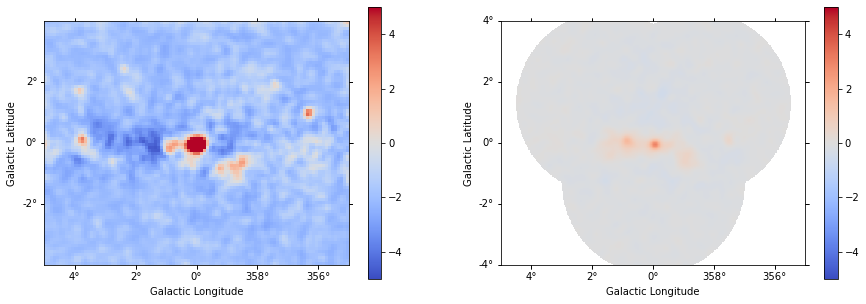

In [24]:
# plot the spatial residuals
plt.figure(figsize=(15, 5))
ax1 = plt.subplot(121, projection=fermi_dataset._geom.wcs)
ax2 = plt.subplot(122, projection=cta_dataset._geom.wcs)


datasets[0].plot_residuals_spatial(ax=ax1)
datasets[1].plot_residuals_spatial(ax=ax2,)

## Model management - convenience functions for loading/freezing/etc

Clearly, there are still multiple sources that are left to be modelled. To do this, we 

- load the Fermi-LAT 4FGL catalog from `gammapy.catalog` 
- To speed up the computation, select only sources within 5 deg of the galactic center
-  use `Models.select_mask()`  to pick the sources in the Fermi ROI. (Alternatively, you may also choose `Models.select_region()`)
- Apply the selected models to the Fermi dataset
- Freeze the parameters of the models for faster convergence of this tutorial
- Do a joint Fermi-CTA modeling of SgrA* - apply the dataset on both the models
- Constrain the parameter ranges of the SgrA*

In [27]:
from gammapy.catalog import SourceCatalog3FHL
catalog = SourceCatalog3FHL()

In [28]:
%%time
gc_sep = catalog.positions.separation(SkyCoord(0,0,unit="deg",frame="galactic"))
models_3fhl = [_.sky_model() for k,_ in enumerate(catalog) if gc_sep[k].value<5] 
models_3fhl = Models(models_3fhl)

CPU times: user 1.41 s, sys: 15.6 ms, total: 1.43 s
Wall time: 1.42 s


In [31]:
#Select the mask in fermi
models_fermi = models_3fhl.select_mask(mask_fermi)
len(models_fermi)

13

We have 13 models in the 4fgl in the chosen field. We first freeze the parameters of all models.
To do this, we simply use `Models.freeze()`. 

In [46]:
models_fermi.freeze() # freeze all components of all models

In [131]:
models.extend(models_fermi)

Q: Can you append `Models` to `Models`?

Now, we choose the central source and apply it on all datasets. This can be simply done by setting `dataets_names=None`. Individual models can be selected from a `Models` object by using `Model.select()`. You can do `help(Models.select)` to see all conditions according to which this selections can be performed 

In [52]:
help(Models.select)

Help on function select in module gammapy.modeling.models.core:

select(self, name_substring=None, datasets_names=None, tag=None, model_type=None, frozen=None)
    Select models that meet all specified conditions
    
    Parameters
    ----------
    
    name_substring : str
        Substring contained in the model name
    datasets_names : str or list
        Name of the dataset
    tag : str or list
        Model tag
    model_type : {None, spatial, spectral}
       Type of model, used together with "tag", if the tag is not unique.
    frozen : bool
        Select models with all parameters frozen if True, exclude them if False.
    
    Returns
    -------
    models : `DatasetModels`
        Selected models



In [65]:
model_SgrA = models_fermi.select(name_substring='J1745.6-2859')[0]
model_SgrA.datasets_names = None


## Freezing and thawing parmeters of an individual model

In [72]:
# Now, lets say we want to unfreeze all the spectral parameters of this model
model_SgrA.unfreeze(model_type='spectral')
print(model_SgrA.parameters.to_table())

  type      name      value         unit      ...    max    frozen   error  
-------- --------- ----------- -------------- ... --------- ------ ---------
spectral amplitude  2.5896e-06 cm-2 s-1 TeV-1 ...       nan  False 6.122e-08
spectral reference  4.0744e-03            TeV ...       nan   True 0.000e+00
spectral     alpha  2.5622e+00                ...       nan  False 2.828e-02
spectral      beta  1.9050e-01                ...       nan  False 1.477e-02
 spatial     lon_0  2.6641e+02            deg ...       nan  False 4.064e-03
 spatial     lat_0 -2.8997e+01            deg ... 9.000e+01  False 3.554e-03


## Removing models from datasets

Models can be removed by specifying their names.
For ex, to remove the SgrA* model, you can simply do

In [75]:
print(len(models_fermi))
models_fermi.remove(models_fermi[0].name)
print(len(models_fermi))  # `diffuse-iem` is removed from the models object

72
71
